# Cart endgame

## Import and load the original data

In [296]:
import sys
sys.path.insert(1, '../') 
from utils.loader import Loader

import pandas as pd
from sklearn import tree
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

In [297]:
data = Loader.load_all()['original']

c:\Users\lingf\Desktop\SRC\Cars_Price_Prediction\CART\..\utils\loader.py:97: DtypeWarning: Columns (120) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path,
c:\Users\lingf\Desktop\SRC\Cars_Price_Prediction\CART\..\utils\loader.py:97: DtypeWarning: Columns (120) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path,
c:\Users\lingf\Desktop\SRC\Cars_Price_Prediction\CART\..\utils\loader.py:109: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original ob

In [298]:
data["Llantas_Diametro_cm"].unique()

array([40.64, 45.72, 50.8 , 43.18, 38.1 , 48.26, 35.56, 53.34, 55.88,
       58.42, 33.02, 12.7 ,   nan, 30.48])

In [299]:
data["fuelType"].value_counts()

fuelType
Diésel                71808
Gasolina              57396
Híbrido               20099
Híbrido enchufable     7955
Eléctrico              6591
Gas licuado (GLP)       930
Gas natural (CNG)       360
Name: count, dtype: int64

In [300]:
def hist_plot(arr, n_bins, title = "hist_plot", x_label = "price", y_label="frecuency"):
    plt.figure(figsize=(8, 6))
    sns.histplot(arr, kde=True, bins=n_bins)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

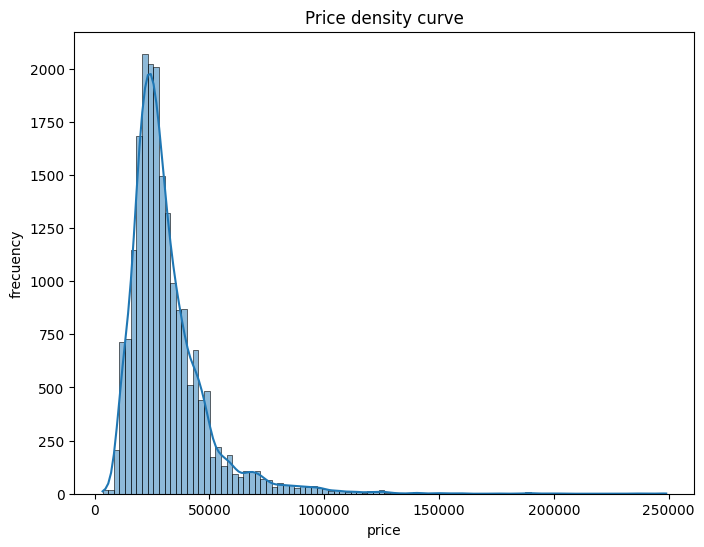

In [301]:
hist_plot(data[data["fuelType"]=="Híbrido"]["price"], n_bins=100, title='Price density curve')

In [302]:
precios_electricos = data[data["fuelType"]=="Eléctrico"]["price"]
print(precios_electricos)

3         27500
7         33150
10        31900
14        25900
18        81900
          ...  
164439    26000
164546    13750
164695    14500
164763    14200
165001     9800
Name: price, Length: 6591, dtype: int64


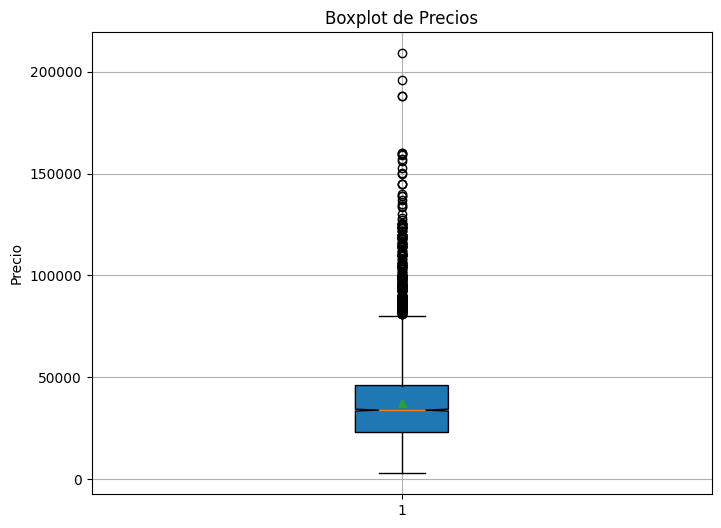

In [303]:
plt.figure(figsize=(8, 6))
plt.boxplot(precios_electricos, notch=True, vert=True, patch_artist=True, showmeans=True)
plt.title('Boxplot de Precios')
plt.ylabel('Precio')
plt.grid(True)
plt.show()

The related outliers were checked manually throught the data source, and we could confirmed that they are not outliers

In [304]:
Q1 = data['price'].quantile(0.25)
Q2 = data['price'].quantile(0.5)  # Esta es la mediana
Q3 = data['price'].quantile(0.75)
IQR = Q3 - Q1

upper_whisker = (Q3 + 1.5 * IQR)
print(upper_whisker)

data[data["fuelType"] == "Eléctrico"][data["price"]>upper_whisker][["price", "brand"]].sort_values(by='price', ascending=False)
#data = data[data["price"]<upper_whisker]

52515.0


C:\Users\lingf\AppData\Local\Temp\ipykernel_71624\4040790187.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data[data["fuelType"] == "Eléctrico"][data["price"]>upper_whisker][["price", "brand"]].sort_values(by='price', ascending=False)


,price,brand
28225,209000,MASERATI
85536,196000,MASERATI
134510,188000,MERCEDES-BENZ
143913,188000,MERCEDES-BENZ
21945,159900,PORSCHE
...,...,...
148082,52600,MINI
40422,52600,PEUGEOT
34583,52600,BMW
34418,52600,AUDI


## Separate the DF in fuelType Categories

We split the dataframe into the categories so in the PCA or CA, we don't discart columns because of the most popular classes

In [305]:
def split_fuel_type(data:pd.DataFrame) -> dict:
    ret={}
    ret["Eléctrico"] = data[data["fuelType"] == "Eléctrico"]
    ret["Combustion"] = data[(data["fuelType"] == "Gasolina") | (data["fuelType"] == "Diésel")]
    ret["Híbrido"] = data[data["fuelType"] == "Híbrido"]
    ret["Híbrido enchufable"] = data[data["fuelType"] == "Híbrido enchufable"]
    ret["Gas"] = data[(data["fuelType"] == "Gas licuado (GLP)") | (data["fuelType"] == "Gas natural (CNG)")]
    return ret

In [306]:
data = split_fuel_type(data)

In [307]:
data.keys()

dict_keys(['Eléctrico', 'Combustion', 'Híbrido', 'Híbrido enchufable', 'Gas'])

## PCA Eléctrico

In [308]:
numerical_columns = data["Eléctrico"].select_dtypes(include=['number'])
numerical_columns.drop(columns=["idx", "car_id", "electricFeatures.maxPower_CV"], inplace=True)

cols_to_drop = numerical_columns.columns[(numerical_columns == 0).all()]
numerical_columns = numerical_columns.drop(cols_to_drop, axis=1)

max_nans = 6586
thresh = numerical_columns.shape[0] - max_nans

numerical_columns.dropna(axis=1, thresh=thresh+1, inplace=True)
numerical_columns

,price,km,year,doors,seatingCapacity,trunkCapacityInLiters,maxSpeed,acceleration,power_cv,power_kw,...,electricFeatures.combinedConsumption_kWh/,electricFeatures.onboardCharger_kW,electricFeatures.standardModeVoltage_V,electricFeatures.standardModeChargeStart_%,electricFeatures.standardModeChargeEnd_%,electricFeatures.fastModeChargeStart_%,electricFeatures.fastModeVoltage_V,electricFeatures.standardModeMaxKW_kW,electricFeatures.fastModeAmps_A,electricFeatures.chargingInformation.standardMode_A
3,27500,13500.0,2022.0,4.0,4.0,185.0,150.0,9.0,118,87,...,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0
7,33150,0.0,2024.0,5.0,5.0,466.0,162.0,8.8,156,115,...,14.0,11.0,220.0,0.0,100.0,10.0,NaN,NaN,NaN,12.0
10,31900,15.0,2022.0,4.0,2.0,NaN,130.0,NaN,122,90,...,29.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,25900,1500.0,2023.0,5.0,5.0,309.0,150.0,9.0,136,100,...,15.0,7.0,230.0,20.0,80.0,20.0,NaN,NaN,NaN,8.0
18,81900,29000.0,2021.0,4.0,5.0,435.0,250.0,3.3,598,440,...,21.0,11.0,NaN,0.0,100.0,5.0,800.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164439,26000,6602.0,2022.0,3.0,4.0,211.0,150.0,7.3,184,135,...,NaN,11.0,NaN,0.0,100.0,0.0,NaN,2.0,NaN,NaN
164546,13750,19800.0,2020.0,3.0,2.0,260.0,130.0,11.6,82,60,...,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
164695,14500,7800.0,2018.0,3.0,2.0,260.0,130.0,11.5,82,60,...,NaN,4.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
164763,14200,14178.0,2020.0,3.0,2.0,260.0,130.0,11.6,82,60,...,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [309]:
numerical_columns.isna().sum()

price                                                     0
km                                                        0
year                                                      0
doors                                                     0
seatingCapacity                                           0
trunkCapacityInLiters                                   585
maxSpeed                                                228
acceleration                                            597
power_cv                                                  0
power_kw                                                  0
rpm_max_power                                          3993
max_torque_nm                                           265
rpm_max_torque                                         3687
speakers                                                  0
cubicCapacity_seat_folded                              1499
dimensions.width                                        163
dimensions.height                       

In [310]:
def fill_na_with_mode(df, column_name, inplace=False):
    # Verificar si la columna existe en el DataFrame
    if column_name in df.columns:
        # Calcular el valor modal de la columna
        mode_value = df[column_name].mode().iloc[0]  # Obtener el primer modo en caso de múltiples modos
        # Rellenar NaN con el valor modal
        df[column_name].fillna(mode_value, inplace=inplace)
    else:
        print(f"La columna '{column_name}' no existe en el DataFrame.")
    return df

def impute_with_linear_regression(data, x_columns, y_column):
    # Separar el DataFrame en partes con y sin NaN en la columna objetivo
    df_with_target = data.dropna(subset=[y_column])
    df_without_target = data[data[y_column].isna()]
    
    # Preparar los datos para la regresión
    X_train = df_with_target[x_columns]
    y_train = df_with_target[y_column]
    X_test = df_without_target[x_columns]
    
    # Crear y entrenar el modelo de regresión lineal
    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_train)
    epsilon = np.finfo(np.float64).eps
    mape = np.mean(np.abs((y_train - y_pred) / (y_train + epsilon))) * 100
    print(f"Regression mape {x_columns} -> {y_column}: {mape}%")
    # Predecir los valores NaN de la columna objetivo
    if not X_test.empty:
        predicted_values = model.predict(X_test)
        data.loc[data[y_column].isna(), y_column] = predicted_values
    
    return data

In [311]:
correlation_matrix = numerical_columns.corr()["electricFeatures.standardChargeDuration_minutos"]
print(correlation_matrix)

price                                                  0.664388
km                                                    -0.279249
year                                                   0.480703
doors                                                  0.140896
seatingCapacity                                        0.381488
trunkCapacityInLiters                                  0.449699
maxSpeed                                               0.514765
acceleration                                          -0.494890
power_cv                                               0.538137
power_kw                                               0.538271
rpm_max_power                                          0.108923
max_torque_nm                                          0.524700
rpm_max_torque                                         0.056208
speakers                                               0.381252
cubicCapacity_seat_folded                             -0.362101
dimensions.width                        

In [312]:
fill_na_with_mode(numerical_columns, "dimensions.length", inplace=True)
fill_na_with_mode(numerical_columns, "dimensions.height", inplace=True)
fill_na_with_mode(numerical_columns, "electricFeatures.maximumBatteryKWH_kWh", inplace=True)
fill_na_with_mode(numerical_columns, "electricFeatures.onboardCharger_kW", inplace=True)
fill_na_with_mode(numerical_columns, "electricFeatures.range_KM", inplace=True)
numerical_columns = impute_with_linear_regression(data=numerical_columns, x_columns=["dimensions.length", "dimensions.height"], y_column="dimensions.width")
numerical_columns = impute_with_linear_regression(data=numerical_columns, x_columns=["dimensions.length", "dimensions.height", "dimensions.width"], y_column="trunkCapacityInLiters")
numerical_columns = impute_with_linear_regression(data=numerical_columns, x_columns=["power_cv", "power_kw"], y_column="maxSpeed")
numerical_columns = impute_with_linear_regression(data=numerical_columns, x_columns=["power_cv", "power_kw", "maxSpeed"], y_column="acceleration")
numerical_columns = impute_with_linear_regression(data=numerical_columns, x_columns=["power_cv", "power_kw", "maxSpeed"], y_column="acceleration")
numerical_columns = impute_with_linear_regression(data=numerical_columns, x_columns=["Llantas_Diametro_cm", "power_kw"], y_column="max_torque_nm")
numerical_columns = impute_with_linear_regression(data=numerical_columns, x_columns=["electricFeatures.maximumBatteryKWH_kWh", "power_kw", "dimensions.length", "dimensions.height", "dimensions.width"], y_column="electricFeatures.combinedConsumption_kWh/")
numerical_columns = impute_with_linear_regression(data=numerical_columns, x_columns=["electricFeatures.maximumBatteryKWH_kWh", "electricFeatures.combinedConsumption_kWh/", "power_kw"], y_column="electricFeatures.range_KM")
numerical_columns.isna().sum()

Regression mape ['dimensions.length', 'dimensions.height'] -> dimensions.width: 1.6468475373043994%
Regression mape ['dimensions.length', 'dimensions.height', 'dimensions.width'] -> trunkCapacityInLiters: 16.91508204296949%
Regression mape ['power_cv', 'power_kw'] -> maxSpeed: 5.689473571028928%
Regression mape ['power_cv', 'power_kw', 'maxSpeed'] -> acceleration: 13.035625391285748%
Regression mape ['power_cv', 'power_kw', 'maxSpeed'] -> acceleration: 11.85488371952156%
Regression mape ['Llantas_Diametro_cm', 'power_kw'] -> max_torque_nm: 17.854083487783583%
Regression mape ['electricFeatures.maximumBatteryKWH_kWh', 'power_kw', 'dimensions.length', 'dimensions.height', 'dimensions.width'] -> electricFeatures.combinedConsumption_kWh/: 17.20475510968712%
Regression mape ['electricFeatures.maximumBatteryKWH_kWh', 'electricFeatures.combinedConsumption_kWh/', 'power_kw'] -> electricFeatures.range_KM: 16.16138222681962%


C:\Users\lingf\AppData\Local\Temp\ipykernel_71624\2190339189.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column_name].fillna(mode_value, inplace=inplace)


price                                                     0
km                                                        0
year                                                      0
doors                                                     0
seatingCapacity                                           0
trunkCapacityInLiters                                     0
maxSpeed                                                  0
acceleration                                              0
power_cv                                                  0
power_kw                                                  0
rpm_max_power                                          3993
max_torque_nm                                             0
rpm_max_torque                                         3687
speakers                                                  0
cubicCapacity_seat_folded                              1499
dimensions.width                                          0
dimensions.height                       

In [313]:
numerical_columns["electricFeatures.onboardCharger_kW"]

3         11.0
7         11.0
10        22.0
14         7.0
18        11.0
          ... 
164439    11.0
164546     4.0
164695     4.0
164763     4.0
165001    11.0
Name: electricFeatures.onboardCharger_kW, Length: 6591, dtype: float64

In [314]:
numerical_columns.dropna(axis=1, inplace=True)
correlation_matrix = numerical_columns.corr()["price"]
print(correlation_matrix)

price                                        1.000000
km                                          -0.343331
year                                         0.459700
doors                                        0.092279
seatingCapacity                              0.257532
trunkCapacityInLiters                        0.301739
maxSpeed                                     0.655830
acceleration                                -0.582307
power_cv                                     0.709338
power_kw                                     0.712126
max_torque_nm                                0.677488
speakers                                     0.294090
dimensions.width                             0.689372
dimensions.height                            0.055209
dimensions.length                            0.613427
Numero_Testigos                              0.183137
Llantas_Diametro_cm                          0.633856
electricFeatures.range_KM                    0.600411
electricFeatures.maximumBatt

In [315]:
scaler = StandardScaler()
df_scaled  = scaler.fit_transform(numerical_columns)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_scaled)
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

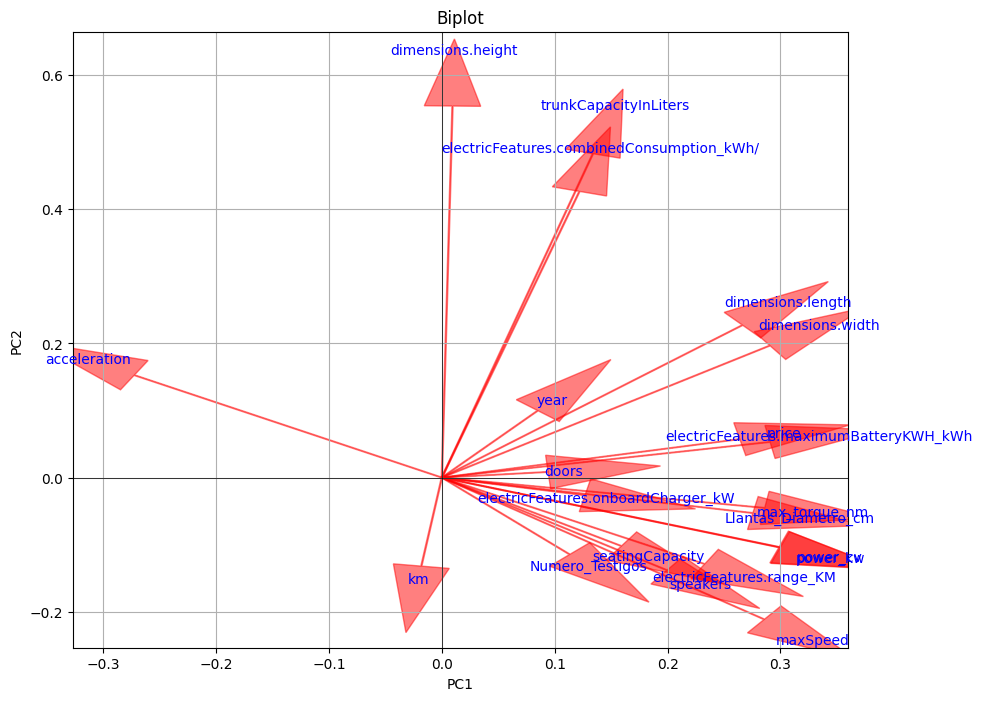

In [316]:
def biplot(score, coeff, labels=None):
    plt.figure(figsize=(10, 8))
    origin = [0, 0]  # Origen de las flechas

    # Dibujar las flechas
    for i in range(len(coeff)):
        plt.arrow(origin[0], origin[1], coeff[i,0], coeff[i,1], color='r', alpha=0.5, head_width=0.05, head_length=0.1)
        if labels is not None:
            plt.text(coeff[i,0]*1.15, coeff[i,1]*1.15, labels[i], color='blue', ha='center', va='center')

    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("Biplot")
    plt.grid(True)
    plt.axhline(0, color='black',linewidth=0.5)
    plt.axvline(0, color='black',linewidth=0.5)
    plt.xlim(min(coeff[:,0])*1.2, max(coeff[:,0])*1.2)
    plt.ylim(min(coeff[:,1])*1.2, max(coeff[:,1])*1.2)
    plt.show()

# Llamada a la función biplot
biplot(principal_components, np.transpose(pca.components_[0:2, :]), labels=numerical_columns.columns)

## Test CART regression trees with only numerical variables

In [317]:
X = numerical_columns.drop(columns="price")
y = numerical_columns["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [318]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Realizar predicciones sobre el conjunto de prueba
y_pred = tree_model.predict(X_test)

# Calcular el MAPE
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Mean Absolute Percentage Error (MAPE): 10.39%


# CA Electricp